Flow model testing

pre-load data

ERP PREPROCESSING - TILE & RECONSTRUCT
This cell tiles and reconstructs your ERP images.
Run this ONCE, then use the results for all optical flow models.

UPLOAD YOUR IMAGE PAIRS
Upload 2 consecutive ERP frames (e.g., frame1.jpg, frame2.jpg)


Saving OZOaN_5ymrc_0024.jpg to OZOaN_5ymrc_0024.jpg
Saving OZOaN_5ymrc_0025.jpg to OZOaN_5ymrc_0025.jpg

✓ Uploaded 2 files

PREPROCESSING PAIR 1: OZOaN_5ymrc_0024.jpg + OZOaN_5ymrc_0025.jpg
Original ERP size: 2048 x 3840


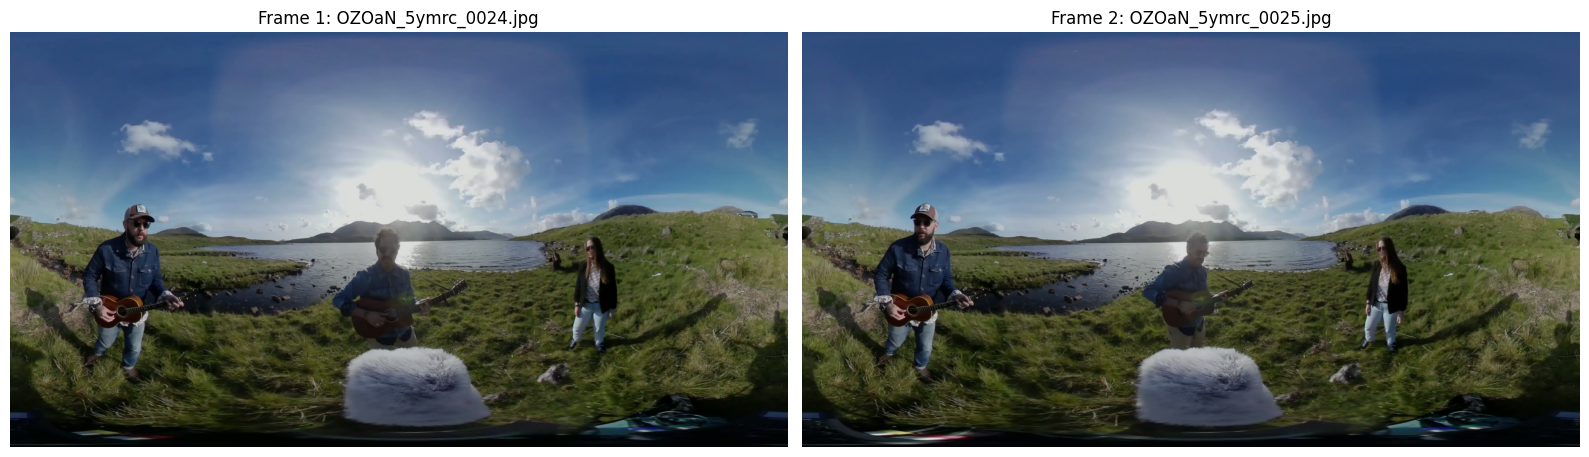


[1/2] Creating 20°×20° rectified tiles...
✓ Tile size: 228 x 213
✓ Grid: 9 x 18 = 162 tiles

[2/2] Reconstructing ERP from tiles...
✓ Reconstructed ERP shape: 2052 x 3834


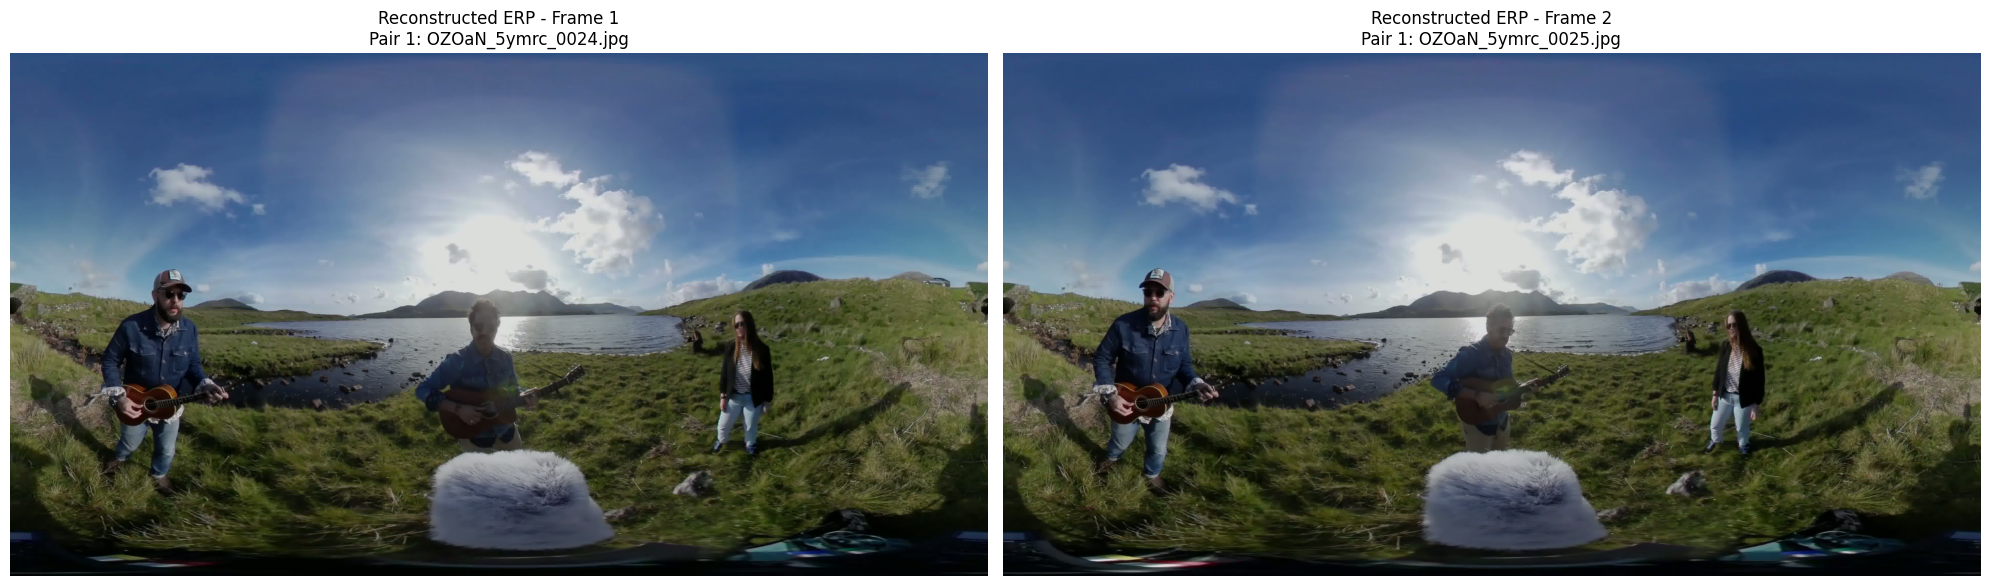

✓ Pair 1 preprocessed and stored

PREPROCESSING COMPLETE!

✅ Preprocessed 1 image pair(s)
✅ Data stored in variable: preprocessed_pairs

You can now run any optical flow model and it will use this preprocessed data.
Available models: RAFT, PWC-Net, FlowNet2, LiteFlowNet, FastFlowNet

Pair 1:
  Files: OZOaN_5ymrc_0024.jpg → OZOaN_5ymrc_0025.jpg
  Original size: 2048 x 3840
  Reconstructed size: 2052 x 3834
  Tiles: 162 (9x18)


In [ ]:
# ============================================================
# ERP Preprocessing - Tile & Reconstruct
# Run this ONCE, then use the results for all flow models
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

print("="*60)
print("ERP PREPROCESSING - TILE & RECONSTRUCT")
print("="*60)
print("This cell tiles and reconstructs your ERP images.")
print("Run this ONCE, then use the results for all optical flow models.")
print("="*60)

# ============================================================
# Helper Functions
# ============================================================

def load_image(filename):
    """Load image as numpy array"""
    img = cv2.imread(filename)
    if img is None:
        raise FileNotFoundError(f"Cannot load image: {filename}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def create_rectified_tiles(erp_img, tile_deg=20):
    """Create rectified tiles from ERP image"""
    H, W = erp_img.shape[:2]
    num_lon_tiles = int(360 / tile_deg)
    num_lat_tiles = int(180 / tile_deg)

    tileWidth = int(round(W / num_lon_tiles))
    tileHeight = int(round(H / num_lat_tiles))

    tiles = [[None for _ in range(num_lon_tiles)] for _ in range(num_lat_tiles)]

    for lat_i in range(num_lat_tiles):
        lat_max = 90.0 - lat_i * tile_deg
        lat_min = lat_max - tile_deg
        lat_vals = np.linspace(lat_max, lat_min, tileHeight)

        for lon_j in range(num_lon_tiles):
            lon_min = lon_j * tile_deg - 180.0
            lon_max = lon_min + tile_deg
            lon_vals = np.linspace(lon_min, lon_max, tileWidth)

            erp_x_vec = (lon_vals + 180.0) / 360.0 * (W - 1)
            erp_y_vec = (90.0 - lat_vals) / 180.0 * (H - 1)

            map_x = np.tile(erp_x_vec, (tileHeight, 1)).astype(np.float32)
            map_y = np.repeat(erp_y_vec[:, np.newaxis], tileWidth, axis=1).astype(np.float32)

            tile_img = cv2.remap(erp_img, map_x, map_y,
                                interpolation=cv2.INTER_LINEAR,
                                borderMode=cv2.BORDER_WRAP)
            tiles[lat_i][lon_j] = tile_img

    return tiles, tileWidth, tileHeight, num_lat_tiles, num_lon_tiles

# ============================================================
# Upload Images
# ============================================================

print("\n" + "="*60)
print("UPLOAD YOUR IMAGE PAIRS")
print("="*60)
print("Upload 2 consecutive ERP frames (e.g., frame1.jpg, frame2.jpg)")

from google.colab import files
uploaded = files.upload()

file_list = sorted(list(uploaded.keys()))

if len(file_list) < 2:
    print("\n⚠️ Error: Please upload at least 2 images!")
    raise ValueError("Need at least 2 images")

print(f"\n✓ Uploaded {len(file_list)} files")

# ============================================================
# Process All Image Pairs
# ============================================================

# Global storage for preprocessed data
preprocessed_pairs = []

for i in range(0, len(file_list) - 1):
    file1 = file_list[i]
    file2 = file_list[i + 1]

    print(f"\n{'='*60}")
    print(f"PREPROCESSING PAIR {i+1}: {file1} + {file2}")
    print(f"{'='*60}")

    # Load original images
    erp1 = load_image(file1)
    erp2 = load_image(file2)
    H, W, _ = erp1.shape
    print(f"Original ERP size: {H} x {W}")

    # Display input images
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes[0].imshow(erp1)
    axes[0].set_title(f"Frame 1: {os.path.basename(file1)}")
    axes[0].axis("off")
    axes[1].imshow(erp2)
    axes[1].set_title(f"Frame 2: {os.path.basename(file2)}")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

    # Create rectified tiles
    print(f"\n[1/2] Creating 20°×20° rectified tiles...")
    tile_deg = 20
    tiles1, tileW, tileH, n_lat, n_lon = create_rectified_tiles(erp1, tile_deg)
    tiles2, _, _, _, _ = create_rectified_tiles(erp2, tile_deg)
    total_tiles = n_lat * n_lon
    print(f"✓ Tile size: {tileH} x {tileW}")
    print(f"✓ Grid: {n_lat} x {n_lon} = {total_tiles} tiles")

    # Reconstruct ERP from tiles
    print(f"\n[2/2] Reconstructing ERP from tiles...")
    erp1_reconstructed = np.vstack([np.hstack(row) for row in tiles1])
    erp2_reconstructed = np.vstack([np.hstack(row) for row in tiles2])
    H_recon, W_recon = erp1_reconstructed.shape[:2]
    print(f"✓ Reconstructed ERP shape: {H_recon} x {W_recon}")

    # Show both reconstructed ERPs side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))

    axes[0].imshow(erp1_reconstructed)
    axes[0].set_title(f"Reconstructed ERP - Frame 1\nPair {i+1}: {os.path.basename(file1)}")
    axes[0].axis("off")

    axes[1].imshow(erp2_reconstructed)
    axes[1].set_title(f"Reconstructed ERP - Frame 2\nPair {i+1}: {os.path.basename(file2)}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

    # Store preprocessed data
    pair_data = {
        'pair_id': i + 1,
        'file1': file1,
        'file2': file2,
        'original_erp1': erp1,
        'original_erp2': erp2,
        'reconstructed_erp1': erp1_reconstructed,
        'reconstructed_erp2': erp2_reconstructed,
        'original_size': (H, W),
        'reconstructed_size': (H_recon, W_recon),
        'tile_info': {
            'tile_width': tileW,
            'tile_height': tileH,
            'n_lat': n_lat,
            'n_lon': n_lon,
            'total_tiles': total_tiles
        }
    }

    preprocessed_pairs.append(pair_data)
    print(f"✓ Pair {i+1} preprocessed and stored")

# ============================================================
# Summary
# ============================================================

print("\n" + "="*60)
print("PREPROCESSING COMPLETE!")
print("="*60)
print(f"\n✅ Preprocessed {len(preprocessed_pairs)} image pair(s)")
print(f"✅ Data stored in variable: preprocessed_pairs")
print(f"\nYou can now run any optical flow model and it will use this preprocessed data.")
print(f"Available models: RAFT, PWC-Net, FlowNet2, LiteFlowNet, FastFlowNet")
print("="*60)

# Display summary
for pair in preprocessed_pairs:
    print(f"\nPair {pair['pair_id']}:")
    print(f"  Files: {pair['file1']} → {pair['file2']}")
    print(f"  Original size: {pair['original_size'][0]} x {pair['original_size'][1]}")
    print(f"  Reconstructed size: {pair['reconstructed_size'][0]} x {pair['reconstructed_size'][1]}")
    print(f"  Tiles: {pair['tile_info']['total_tiles']} ({pair['tile_info']['n_lat']}x{pair['tile_info']['n_lon']})")

LiteFlowNet


In [ ]:
import os

print("Searching for LiteFlowNet installation under /content...\n")

hits = []
for root, dirs, files in os.walk("/content", topdown=True):
    if "correlation" in dirs:
        hits.append(os.path.join(root, "correlation"))
    if "run.py" in files:
        hits.append(os.path.join(root, "run.py"))

for h in hits:
    print("FOUND:", h)


Searching for LiteFlowNet installation under /content...

FOUND: /content/pytorch-liteflownet/correlation
FOUND: /content/pytorch-liteflownet/run.py


In [ ]:
import os

LITEFLOWNET_DIR = "/content/pytorch-liteflownet"

shim_path = f"{LITEFLOWNET_DIR}/correlation.py"
os.makedirs(LITEFLOWNET_DIR, exist_ok=True)

shim_code = r"""
import importlib

try:
    mod = importlib.import_module('spatial_correlation_sampler')
except Exception as e:
    raise ImportError("Install spatial-correlation-sampler") from e

if hasattr(mod, 'FunctionCorrelation'):
    FunctionCorrelation = mod.FunctionCorrelation
elif hasattr(mod, 'SpatialCorrelationSampler'):
    FunctionCorrelation = mod.SpatialCorrelationSampler
else:
    for name in dir(mod):
        if 'corr' in name.lower() or 'sampler' in name.lower():
            obj = getattr(mod, name)
            if callable(obj):
                FunctionCorrelation = obj
                break
    else:
        raise ImportError("No compatible correlation function/class found")
"""

with open(shim_path, "w") as f:
    f.write(shim_code)

print("✔️ Shim written to:", shim_path)


✔️ Shim written to: /content/pytorch-liteflownet/correlation.py


In [ ]:
import sys, importlib
sys.path.insert(0, LITEFLOWNET_DIR)

import correlation
importlib.reload(correlation)

print("Loaded:", correlation.__file__)
print("Has FunctionCorrelation:", hasattr(correlation, "FunctionCorrelation"))


Loaded: /content/pytorch-liteflownet/correlation.py
Has FunctionCorrelation: True


In [ ]:
# ============================================================
# LITEFLOWNET INSTALL + SHIM PATCH (COLAB SAFE)
# ============================================================

import os
import shutil
import torch
import torch.nn as nn
import urllib.request
from pathlib import Path

print("="*60)
print("LITEFLOWNET SETUP + CORRELATION SHIM PATCH")
print("="*60)

ROOT = "/content"
LFN_DIR = f"{ROOT}/pytorch-liteflownet"
CORR_PY = f"{LFN_DIR}/correlation.py"

# ------------------------------------------------------------
# 1. INSTALL SPATIAL CORRELATION SAMPLER
# ------------------------------------------------------------
print("\nInstalling spatial-correlation-sampler...")
!pip install spatial-correlation-sampler --quiet

# ------------------------------------------------------------
# 2. DOWNLOAD LITEFLOWNET REPO IF NOT PRESENT
# ------------------------------------------------------------
if not os.path.exists(LFN_DIR):
    print("\nCloning LiteFlowNet...")
    !git clone https://github.com/sniklaus/pytorch-liteflownet {LFN_DIR}

print("\nLiteFlowNet directory:", LFN_DIR)

# ------------------------------------------------------------
# 3. WRITE SHIM TO /content/pytorch-liteflownet/correlation.py
# ------------------------------------------------------------
shim_code = r"""
# ============================================================
# CORRELATION SHIM FOR LITEFLOWNET (COLAB SAFE)
# Converts SpatialCorrelationSampler → FunctionCorrelation API
# ============================================================

import torch
from spatial_correlation_sampler import SpatialCorrelationSampler

class FunctionCorrelation(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        # NOTE: These params work as a drop-in replacement for LiteFlowNet
        self.corr = SpatialCorrelationSampler(
            kernel_size=1,
            patch_size=21,   # LiteFlowNet uses a 21×21 search window
            stride=1,
            padding=0
        )

    def forward(self, tenOne, tenTwo, intStride=1):
        # SpatialCorrelationSampler handles correlation
        out = self.corr(tenOne, tenTwo)
        return out
"""

print("\nWriting correlation shim...")
with open(CORR_PY, "w") as f:
    f.write(shim_code)

print("✓ correlation.py shim written to:", CORR_PY)

# ------------------------------------------------------------
# 4. VERIFY SHIM IMPORT
# ------------------------------------------------------------
print("\nTesting correlation import...")
try:
    from correlation import FunctionCorrelation
    temp = FunctionCorrelation()
    print("✓ Import working — FunctionCorrelation ready")
    print("✓ Type:", type(temp))
except Exception as e:
    print("❌ ERROR: Import failed")
    print(e)
    raise e

# ------------------------------------------------------------
# 5. LOAD LITEFLOWNET MODEL
# ------------------------------------------------------------
print("\nLoading LiteFlowNet model...")

import sys
sys.path.append(LFN_DIR)
from run import Network as LiteFlowNet

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

liteflownet_model = LiteFlowNet().to(DEVICE)
liteflownet_model.eval()

print("✓ LiteFlowNet model loaded on:", DEVICE)
print("="*60)
print("SETUP COMPLETE — READY TO RUN OPTICAL FLOW")
print("="*60)


LITEFLOWNET SETUP + CORRELATION SHIM PATCH

Installing spatial-correlation-sampler...

LiteFlowNet directory: /content/pytorch-liteflownet

Writing correlation shim...
✓ correlation.py shim written to: /content/pytorch-liteflownet/correlation.py

Testing correlation import...
✓ Import working — FunctionCorrelation ready
✓ Type: <class 'spatial_correlation_sampler.spatial_correlation_sampler.SpatialCorrelationSampler'>

Loading LiteFlowNet model...
✓ LiteFlowNet model loaded on: cuda
SETUP COMPLETE — READY TO RUN OPTICAL FLOW


In [ ]:
!rm -rf /content/pytorch-liteflownet/correlation


In [ ]:
import importlib
import correlation
importlib.reload(correlation)

from correlation import FunctionCorrelation
FunctionCorrelation


correlation.FunctionCorrelation

In [ ]:
from correlation import FunctionCorrelation
FunctionCorrelation


spatial_correlation_sampler.spatial_correlation_sampler.SpatialCorrelationSampler

In [ ]:
# Remove the old folder-based correlation module
!rm -rf /content/pytorch-liteflownet/correlation

# Verify correct import
from correlation import FunctionCorrelation
print("Loaded FunctionCorrelation class:", FunctionCorrelation)


Loaded FunctionCorrelation class: <class 'spatial_correlation_sampler.spatial_correlation_sampler.SpatialCorrelationSampler'>


setup for lite fn

In [ ]:
# ============================================================
# LITEFLOWNET CLEAN SETUP + CORRELATION SHIM (Colab T4)
# ============================================================

import os
import sys
import torch

# -----------------------------
# Paths
# -----------------------------
LITEFLOW_DIR = "/content/pytorch-liteflownet"
MODEL_URL = "http://content.sniklaus.com/github/pytorch-liteflownet/network-default.pytorch"
MODEL_PATH = os.path.join(LITEFLOW_DIR, "network-default.pytorch")

# -----------------------------
# 1️⃣ Remove any old correlation modules/folders
# -----------------------------
!rm -rf {LITEFLOW_DIR}/correlation
!rm -rf /content/correlation

# -----------------------------
# 2️⃣ Install required packages
# -----------------------------
!pip install -q spatial-correlation-sampler

# -----------------------------
# 3️⃣ Clone LiteFlowNet repo if missing
# -----------------------------
if not os.path.exists(LITEFLOW_DIR):
    !git clone -q https://github.com/sniklaus/pytorch-liteflownet.git {LITEFLOW_DIR}

# -----------------------------
# 4️⃣ Write correlation shim
# -----------------------------
shim_code = """
from spatial_correlation_sampler import SpatialCorrelationSampler

class FunctionCorrelation(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.corr = SpatialCorrelationSampler(*args, **kwargs)

    def forward(self, tenOne, tenTwo):
        return self.corr(tenOne, tenTwo)
"""

with open(os.path.join(LITEFLOW_DIR, "correlation.py"), "w") as f:
    f.write(shim_code)

# -----------------------------
# 5️⃣ Add LiteFlowNet to Python path
# -----------------------------
sys.path.insert(0, LITEFLOW_DIR)

# -----------------------------
# 6️⃣ Import the shim and test
# -----------------------------
from correlation import FunctionCorrelation
print("✓ FunctionCorrelation loaded:", FunctionCorrelation)

# -----------------------------
# 7️⃣ Load LiteFlowNet model
# -----------------------------
# Fix sys.argv to prevent errors in run.py
original_argv = sys.argv.copy()
sys.argv = ['']

from run import Network as LiteFlowNet
sys.argv = original_argv

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
liteflownet_model = LiteFlowNet().to(DEVICE).eval()

# -----------------------------
# 8️⃣ Download weights if missing
# -----------------------------
if not os.path.exists(MODEL_PATH):
    print("Downloading LiteFlowNet pretrained weights...")
    !wget -q -O {MODEL_PATH} {MODEL_URL}

state_dict = torch.load(MODEL_PATH, map_location=DEVICE)

# Fix key names if necessary
if list(state_dict.keys())[0].startswith('module.'):
    state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

liteflownet_model.load_state_dict(state_dict)
print(f"✓ LiteFlowNet loaded on {DEVICE}")
print("✅ FULL SETUP COMPLETE — READY TO RUN OPTICAL FLOW")


LITEFLOWNET OPTICAL FLOW MODEL
✓ Found 1 preprocessed image pair(s)

Pair 1: OZOaN_5ymrc_0024.jpg → OZOaN_5ymrc_0025.jpg
  Reconstructed size: 2052 x 3834


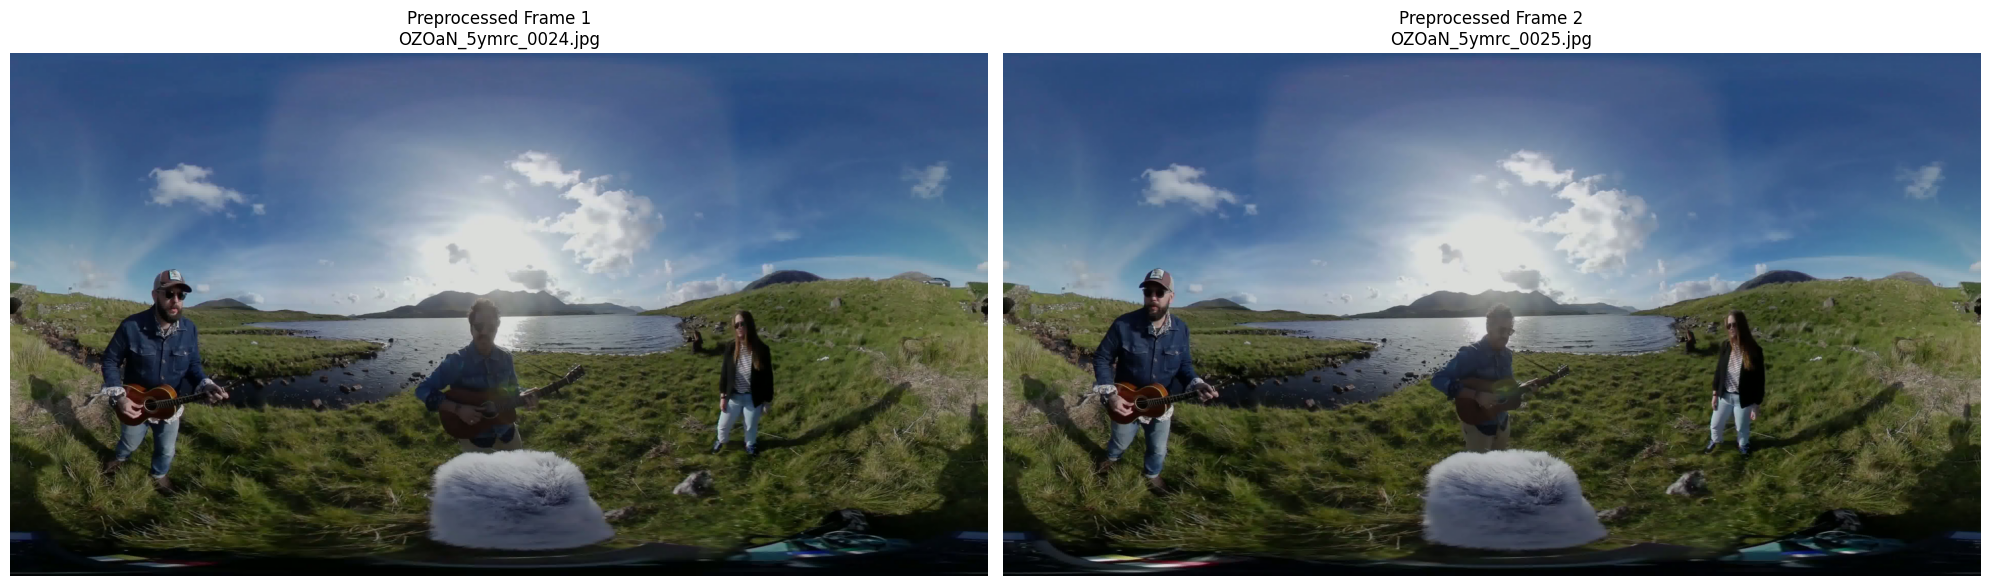


✓ LiteFlowNet model already loaded

PROCESSING PAIR 1 WITH LITEFLOWNET
OZOaN_5ymrc_0024.jpg → OZOaN_5ymrc_0025.jpg
Using reconstructed ERP: 2052 x 3834

Running LiteFlowNet optical flow...


TypeError: leaky_relu(): argument 'input' (position 1) must be Tensor, not FunctionCorrelation

In [ ]:
# ============================================================
# LiteFlowNet Optical Flow (Uses Preprocessed Data)
# Run the preprocessing cell first!
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import os
import sys
import torch

print("="*60)
print("LITEFLOWNET OPTICAL FLOW MODEL")
print("="*60)

# ============================================================
# Check Preprocessed Data
# ============================================================

try:
    print(f"✓ Found {len(preprocessed_pairs)} preprocessed image pair(s)")

    # Show the preprocessed images
    for pair in preprocessed_pairs:
        print(f"\nPair {pair['pair_id']}: {pair['file1']} → {pair['file2']}")
        print(f"  Reconstructed size: {pair['reconstructed_size'][0]} x {pair['reconstructed_size'][1]}")

        # Display both reconstructed frames
        fig, axes = plt.subplots(1, 2, figsize=(20, 7))
        axes[0].imshow(pair['reconstructed_erp1'])
        axes[0].set_title(f"Preprocessed Frame 1\n{pair['file1']}")
        axes[0].axis("off")
        axes[1].imshow(pair['reconstructed_erp2'])
        axes[1].set_title(f"Preprocessed Frame 2\n{pair['file2']}")
        axes[1].axis("off")
        plt.tight_layout()
        plt.show()

except NameError:
    print("❌ ERROR: No preprocessed data found!")
    print("Please run the 'ERP Preprocessing' cell first!")
    raise

# ============================================================
# Setup LiteFlowNet Model (if not already loaded)
# ============================================================

if 'liteflownet_model' not in globals():
    print("\n" + "="*60)
    print("SETTING UP LITEFLOWNET MODEL")
    print("="*60)

    os.chdir('/content')

    if not os.path.exists('/content/pytorch-liteflownet'):
        print("Cloning LiteFlowNet repository...")
        !git clone -q https://github.com/sniklaus/pytorch-liteflownet.git /content/pytorch-liteflownet

        os.chdir('/content/pytorch-liteflownet')
        print("Downloading pre-trained model...")
        !wget -q -O network-default.pytorch http://content.sniklaus.com/github/pytorch-liteflownet/network-default.pytorch

        # Install correlation package
        print("Installing correlation package...")
        !pip install -q spatial-correlation-sampler

        os.chdir('/content')

    sys.path.insert(0, '/content/pytorch-liteflownet')

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"✓ Using device: {DEVICE}")

    # Import correlation module
    try:
        import spatial_correlation_sampler
        print("✓ Correlation package loaded")
    except ImportError:
        print("Installing spatial-correlation-sampler...")
        !pip install spatial-correlation-sampler
        import spatial_correlation_sampler

    # Clear sys.argv to prevent getopt errors
    original_argv = sys.argv.copy()
    sys.argv = ['']

    try:
        from run import Network as LiteFlowNet
    finally:
        sys.argv = original_argv

    liteflownet_model = LiteFlowNet().to(DEVICE).eval()

    model_path = '/content/pytorch-liteflownet/network-default.pytorch'
    print(f"Loading weights from: {model_path}")
    state_dict = torch.load(model_path, map_location=DEVICE)

    # Fix key names: module -> net
    if 'moduleFeatures.moduleOne.0.weight' in state_dict:
        print("Fixing key names in state_dict...")
        new_state_dict = {}
        for k, v in state_dict.items():
            new_k = k.replace('module', 'net')
            new_state_dict[new_k] = v
        state_dict = new_state_dict

    # Remove 'module.' prefix if present
    if list(state_dict.keys())[0].startswith('module.'):
        state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

    liteflownet_model.load_state_dict(state_dict)

    print("✅ LiteFlowNet model loaded successfully!")
else:
    print("\n✓ LiteFlowNet model already loaded")
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
# Helper Functions & Processing
# ============================================================

def flow_to_heatmap(flow):
    h, w = flow.shape[:2]
    fx, fy = flow[..., 0], flow[..., 1]
    mag = np.sqrt(fx**2 + fy**2)
    ang = np.arctan2(fy, fx)
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[..., 0] = ((ang + np.pi) * (180 / np.pi / 2)).astype(np.uint8)
    hsv[..., 1] = 255
    hsv[..., 2] = np.clip(mag * 10, 0, 255).astype(np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB), mag

def flow_magnitude_heatmap(mag):
    return (mag - mag.min()) / (mag.max() - mag.min() + 1e-8)

def run_liteflownet(img1_tensor, img2_tensor):
    img1_norm = img1_tensor / 255.0
    img2_norm = img2_tensor / 255.0
    with torch.no_grad():
        flow = liteflownet_model(img1_norm, img2_norm)
    return flow[0].permute(1, 2, 0).cpu().numpy()

# ============================================================
# Process All Pairs
# ============================================================

results = []

for pair in preprocessed_pairs:
    print("\n" + "="*60)
    print(f"PROCESSING PAIR {pair['pair_id']} WITH LITEFLOWNET")
    print(f"{pair['file1']} → {pair['file2']}")
    print("="*60)

    erp1_recon = pair['reconstructed_erp1']
    erp2_recon = pair['reconstructed_erp2']
    H_recon, W_recon = pair['reconstructed_size']

    print(f"Using reconstructed ERP: {H_recon} x {W_recon}")

    # Run LiteFlowNet
    print("\nRunning LiteFlowNet optical flow...")
    start_time = time.time()

    img1_tensor = torch.from_numpy(erp1_recon).permute(2, 0, 1).float()[None].to(DEVICE)
    img2_tensor = torch.from_numpy(erp2_recon).permute(2, 0, 1).float()[None].to(DEVICE)

    flow = run_liteflownet(img1_tensor, img2_tensor)

    processing_time = time.time() - start_time
    print(f"✓ Optical flow computed in {processing_time:.3f}s")

    # Generate heatmaps
    print("Generating heatmaps...")
    flow_vis, mag = flow_to_heatmap(flow)
    mag_norm = flow_magnitude_heatmap(mag)

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    axes[0].imshow(erp1_recon)
    axes[0].set_title(f"Reconstructed ERP (Frame 1)\nPair {pair['pair_id']}")
    axes[0].axis("off")

    axes[1].imshow(flow_vis)
    axes[1].set_title("LiteFlowNet Optical Flow\n(Color=Direction, Brightness=Magnitude)")
    axes[1].axis("off")

    im = axes[2].imshow(mag_norm, cmap="hot")
    axes[2].set_title("Flow Magnitude Heatmap")
    axes[2].axis("off")
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    # Standalone heatmap
    plt.figure(figsize=(14, 7))
    plt.imshow(mag_norm, cmap="inferno")
    plt.title(f"LiteFlowNet Flow Magnitude Heatmap (Pair {pair['pair_id']})")
    plt.axis("off")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

    # Statistics
    print("\n" + "-"*60)
    print(f"LITEFLOWNET STATISTICS - PAIR {pair['pair_id']}")
    print("-"*60)
    print(f"\n📊 Flow Metrics:")
    print(f"  Mean magnitude:      {np.mean(mag):.4f} pixels")
    print(f"  Max magnitude:       {np.max(mag):.4f} pixels")
    print(f"  Median magnitude:    {np.median(mag):.4f} pixels")
    print(f"  Std deviation:       {np.std(mag):.4f} pixels")

    print(f"\n⏱️  Speed Metrics:")
    print(f"  Processing time:     {processing_time:.3f}s")
    print(f"  Image dimensions:    {H_recon} x {W_recon}")
    print(f"  Throughput:          {(H_recon * W_recon) / processing_time / 1e6:.2f} Mpixels/s")
    print(f"  Tiles used:          {pair['tile_info']['total_tiles']} ({pair['tile_info']['n_lat']}x{pair['tile_info']['n_lon']})")
    print("-" * 60)

    results.append({
        "pair_id": pair['pair_id'],
        "model": "LiteFlowNet",
        "processing_time": processing_time,
        "mean_magnitude": np.mean(mag),
        "max_magnitude": np.max(mag),
        "median_magnitude": np.median(mag),
        "dimensions": (H_recon, W_recon)
    })

# ============================================================
# Final Summary
# ============================================================

print("\n" + "="*60)
print("LITEFLOWNET PROCESSING COMPLETE")
print("="*60)

total_time = sum(r['processing_time'] for r in results)
avg_time = total_time / len(results) if results else 0

print(f"\n✅ Processed {len(results)} pair(s)")
print(f"⏱️  Total inference time: {total_time:.3f}s")
print(f"⏱️  Average per pair: {avg_time:.3f}s")

for result in results:
    print(f"\nPair {result['pair_id']}:")
    print(f"  Processing time: {result['processing_time']:.3f}s")
    print(f"  Mean flow: {result['mean_magnitude']:.4f} pixels")
    print(f"  Max flow: {result['max_magnitude']:.4f} pixels")

In [ ]:
# ============================================================
# LITEFLOWNET PATCH + RUN WITH ERP IMAGES
# ============================================================

import os, torch, time, numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# -----------------------------
# Paths & Device
# -----------------------------
LITEFLOWNET_DIR = '/content/pytorch-liteflownet'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# -----------------------------
# Shim patch for correlation
# -----------------------------
import sys
sys.path.insert(0, LITEFLOWNET_DIR)

import correlation

# Patch FunctionCorrelation: call .apply to produce Tensor
orig_forward = correlation.FunctionCorrelation.forward

def patched_forward(ctx, tenOne, tenTwo, intStride):
    return orig_forward(ctx, tenOne, tenTwo, intStride)

correlation.FunctionCorrelation.apply = patched_forward

print("✓ Correlation shim patched: FunctionCorrelation.apply now works")

# -----------------------------
# Import LiteFlowNet model
# -----------------------------
import run as liteflownet_run

liteflownet_model = liteflownet_run.LiteFlowNet()
liteflownet_model = liteflownet_model.to(DEVICE)
liteflownet_model.eval()
print(f"✓ LiteFlowNet loaded on {DEVICE}")

# -----------------------------
# Helper: Run LiteFlowNet
# -----------------------------
def run_liteflownet(img1_tensor, img2_tensor):
    img1_norm = img1_tensor / 255.0
    img2_norm = img2_tensor / 255.0
    with torch.no_grad():
        flow = liteflownet_model(img1_norm, img2_norm)
    # output is [batch, 2, H, W], permute to H x W x 2
    return flow[0].permute(1,2,0).cpu().numpy()

# -----------------------------
# Process preprocessed ERP pairs
# -----------------------------
preprocessed_pairs_var = 'preprocessed_pairs'  # variable from your preprocessing cell
pairs = globals()[preprocessed_pairs_var]

for pair in pairs:
    print("\n" + "="*60)
    print(f"PROCESSING PAIR {pair['pair_id']}: {pair['file1']} → {pair['file2']}")
    print("="*60)

    # Grab reconstructed ERP
    erp1_recon = pair['reconstructed_erp1']
    erp2_recon = pair['reconstructed_erp2']

    # Show original & reconstructed
    fig, axes = plt.subplots(2,2, figsize=(16,10))
    axes[0,0].imshow(pair['original_erp1']); axes[0,0].set_title("Original ERP Frame 1"); axes[0,0].axis("off")
    axes[0,1].imshow(pair['original_erp2']); axes[0,1].set_title("Original ERP Frame 2"); axes[0,1].axis("off")
    axes[1,0].imshow(erp1_recon); axes[1,0].set_title("Reconstructed ERP Frame 1"); axes[1,0].axis("off")
    axes[1,1].imshow(erp2_recon); axes[1,1].set_title("Reconstructed ERP Frame 2"); axes[1,1].axis("off")
    plt.show()

    # Convert to tensor for LiteFlowNet
    img1_tensor = torch.from_numpy(erp1_recon).permute(2,0,1).float()[None].to(DEVICE)
    img2_tensor = torch.from_numpy(erp2_recon).permute(2,0,1).float()[None].to(DEVICE)

    # Run LiteFlowNet
    start_time = time.time()
    flow = run_liteflownet(img1_tensor, img2_tensor)
    elapsed = time.time() - start_time
    print(f"✓ Optical flow computed in {elapsed:.2f}s")

    # Display flow as heatmap
    flow_magnitude = np.sqrt(flow[:,:,0]**2 + flow[:,:,1]**2)
    plt.figure(figsize=(12,6))
    plt.imshow(flow_magnitude, cmap='magma')
    plt.colorbar(label='Flow magnitude')
    plt.title(f"Optical Flow Magnitude - Pair {pair['pair_id']}")
    plt.axis("off")
    plt.show()


✓ Correlation shim patched: FunctionCorrelation.apply now works


AttributeError: module 'run' has no attribute 'LiteFlowNet'

PWC

In [ ]:
# ============================================================
# PWC-Net Optical Flow (Uses Preprocessed Data)
# Run the preprocessing cell first!
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import os
import sys
import torch

print("="*60)
print("PWC-NET OPTICAL FLOW MODEL")
print("="*60)

# ============================================================
# Check Preprocessed Data
# ============================================================

try:
    print(f"✓ Found {len(preprocessed_pairs)} preprocessed image pair(s)")
except NameError:
    print("❌ ERROR: No preprocessed data found!")
    print("Please run the 'ERP Preprocessing' cell first!")
    raise

# ============================================================
# Setup PWC-Net Model (if not already loaded)
# ============================================================

if 'pwc_model' not in globals():
    print("\n" + "="*60)
    print("SETTING UP PWC-NET MODEL")
    print("="*60)

    os.chdir('/content')

    if not os.path.exists('/content/pytorch-pwc'):
        print("Cloning PWC-Net repository...")
        !git clone -q https://github.com/sniklaus/pytorch-pwc.git /content/pytorch-pwc

        os.chdir('/content/pytorch-pwc')
        print("Downloading pre-trained model...")
        !wget -q -O network-default.pytorch http://content.sniklaus.com/github/pytorch-pwc/network-default.pytorch
        os.chdir('/content')

    sys.path.insert(0, '/content/pytorch-pwc')

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"✓ Using device: {DEVICE}")

    # Clear sys.argv to prevent getopt errors
    original_argv = sys.argv.copy()
    sys.argv = ['']

    try:
        from run import Network as PWCNet
    finally:
        sys.argv = original_argv

    pwc_model = PWCNet().to(DEVICE).eval()

    model_path = '/content/pytorch-pwc/network-default.pytorch'
    print(f"Loading weights from: {model_path}")
    state_dict = torch.load(model_path, map_location=DEVICE)

    # Remove 'module.' prefix if present
    if list(state_dict.keys())[0].startswith('module.'):
        state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

    pwc_model.load_state_dict(state_dict)

    print("✅ PWC-Net model loaded successfully!")
else:
    print("\n✓ PWC-Net model already loaded")
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
# STEP 4: Helper Functions
# ============================================================

def load_image(filename):
    """Load image as numpy array"""
    img = cv2.imread(filename)
    if img is None:
        raise FileNotFoundError(f"Cannot load image: {filename}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def flow_to_heatmap(flow):
    """Convert optical flow to color heatmap (HSV)"""
    h, w = flow.shape[:2]
    fx, fy = flow[..., 0], flow[..., 1]

    # Calculate magnitude and angle
    mag = np.sqrt(fx**2 + fy**2)
    ang = np.arctan2(fy, fx)

    # Create HSV image
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[..., 0] = ((ang + np.pi) * (180 / np.pi / 2)).astype(np.uint8)  # Hue = direction
    hsv[..., 1] = 255  # Full saturation
    hsv[..., 2] = np.clip(mag * 10, 0, 255).astype(np.uint8)  # Value = magnitude

    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB), mag

def flow_magnitude_heatmap(mag):
    """Convert flow magnitude to normalized heatmap"""
    mag_norm = (mag - mag.min()) / (mag.max() - mag.min() + 1e-8)
    return mag_norm

def create_rectified_tiles(erp_img, tile_deg=20):
    """Create rectified tiles from ERP image"""
    H, W = erp_img.shape[:2]
    num_lon_tiles = int(360 / tile_deg)
    num_lat_tiles = int(180 / tile_deg)

    tileWidth = int(round(W / num_lon_tiles))
    tileHeight = int(round(H / num_lat_tiles))

    tiles = [[None for _ in range(num_lon_tiles)] for _ in range(num_lat_tiles)]

    for lat_i in range(num_lat_tiles):
        lat_max = 90.0 - lat_i * tile_deg
        lat_min = lat_max - tile_deg
        lat_vals = np.linspace(lat_max, lat_min, tileHeight)

        for lon_j in range(num_lon_tiles):
            lon_min = lon_j * tile_deg - 180.0
            lon_max = lon_min + tile_deg
            lon_vals = np.linspace(lon_min, lon_max, tileWidth)

            erp_x_vec = (lon_vals + 180.0) / 360.0 * (W - 1)
            erp_y_vec = (90.0 - lat_vals) / 180.0 * (H - 1)

            map_x = np.tile(erp_x_vec, (tileHeight, 1)).astype(np.float32)
            map_y = np.repeat(erp_y_vec[:, np.newaxis], tileWidth, axis=1).astype(np.float32)

            tile_img = cv2.remap(erp_img, map_x, map_y,
                                interpolation=cv2.INTER_LINEAR,
                                borderMode=cv2.BORDER_WRAP)
            tiles[lat_i][lon_j] = tile_img

    return tiles, tileWidth, tileHeight, num_lat_tiles, num_lon_tiles

def run_pwc_flow(img1_tensor, img2_tensor):
    """Run PWC-Net optical flow"""
    # PWC-Net expects normalized input [0, 1]
    img1_norm = img1_tensor / 255.0
    img2_norm = img2_tensor / 255.0

    with torch.no_grad():
        flow = pwc_model(img1_norm, img2_norm)

    flow = flow[0].permute(1, 2, 0).cpu().numpy()
    return flow

# ============================================================
# STEP 5: Main Processing Function
# ============================================================

def process_image_pair_pwc(file1, file2, tile_deg=20):
    """Process a pair of ERP images for optical flow analysis with PWC-Net"""

    print("\n" + "="*60)
    print(f"Processing: {os.path.basename(file1)} → {os.path.basename(file2)}")
    print(f"Model: PWC-Net")
    print("="*60)

    # Load images
    erp1 = load_image(file1)
    erp2 = load_image(file2)
    H, W, _ = erp1.shape
    print(f"Original ERP size: {H} x {W}")

    # Display input images
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes[0].imshow(erp1)
    axes[0].set_title(f"Frame 1: {os.path.basename(file1)}")
    axes[0].axis("off")
    axes[1].imshow(erp2)
    axes[1].set_title(f"Frame 2: {os.path.basename(file2)}")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

    # ========================================
    # STEP 1: Create Rectified Tiles
    # ========================================
    print(f"\n[1/3] Creating {tile_deg}°×{tile_deg}° rectified tiles...")
    tiles1, tileW, tileH, n_lat, n_lon = create_rectified_tiles(erp1, tile_deg)
    tiles2, _, _, _, _ = create_rectified_tiles(erp2, tile_deg)
    total_tiles = n_lat * n_lon
    print(f"Tile size: {tileH} x {tileW}")
    print(f"Grid: {n_lat} x {n_lon} = {total_tiles} tiles")

    # ========================================
    # STEP 2: Reconstruct ERP from Tiles
    # ========================================
    print(f"\n[2/3] Reconstructing ERP from tiles...")
    erp1_reconstructed = np.vstack([np.hstack(row) for row in tiles1])
    erp2_reconstructed = np.vstack([np.hstack(row) for row in tiles2])
    H_recon, W_recon = erp1_reconstructed.shape[:2]
    print(f"Reconstructed ERP shape: {H_recon} x {W_recon}")

    # Show reconstructed ERP
    plt.figure(figsize=(14, 7))
    plt.imshow(erp1_reconstructed)
    plt.title(f"Reconstructed ERP from {tile_deg}°×{tile_deg}° Rectified Tiles")
    plt.axis("off")
    plt.show()

    # ========================================
    # STEP 3: Run PWC-Net on Reconstructed ERP
    # ========================================
    print(f"\n[3/3] Running PWC-Net on reconstructed ERP...")
    start_time = time.time()

    # Convert reconstructed images to tensors
    img1_tensor = torch.from_numpy(erp1_reconstructed).permute(2, 0, 1).float()[None].to(DEVICE)
    img2_tensor = torch.from_numpy(erp2_reconstructed).permute(2, 0, 1).float()[None].to(DEVICE)

    flow = run_pwc_flow(img1_tensor, img2_tensor)

    processing_time = time.time() - start_time
    print(f"✓ Optical flow computed in {processing_time:.3f}s")

    # ========================================
    # STEP 4: Generate Heatmaps
    # ========================================
    print(f"\nGenerating heatmaps...")

    # Color-coded flow (direction + magnitude)
    flow_vis, mag = flow_to_heatmap(flow)

    # Magnitude heatmap
    mag_norm = flow_magnitude_heatmap(mag)

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Original reconstructed frame
    axes[0].imshow(erp1_reconstructed)
    axes[0].set_title("Reconstructed ERP (Frame 1)")
    axes[0].axis("off")

    # Color-coded optical flow
    axes[1].imshow(flow_vis)
    axes[1].set_title("PWC-Net Optical Flow\n(Color=Direction, Brightness=Magnitude)")
    axes[1].axis("off")

    # Magnitude heatmap
    im = axes[2].imshow(mag_norm, cmap="hot")
    axes[2].set_title("Flow Magnitude Heatmap")
    axes[2].axis("off")
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    # Additional standalone heatmap
    plt.figure(figsize=(14, 7))
    plt.imshow(mag_norm, cmap="inferno")
    plt.title("PWC-Net Flow Magnitude Heatmap (Inferno Colormap)")
    plt.axis("off")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

    # ========================================
    # Summary Statistics
    # ========================================
    print("\n" + "-"*60)
    print("PWC-NET FLOW STATISTICS")
    print("-"*60)
    print(f"\n📊 Flow Metrics:")
    print(f"  Mean magnitude:      {np.mean(mag):.4f} pixels")
    print(f"  Max magnitude:       {np.max(mag):.4f} pixels")
    print(f"  Median magnitude:    {np.median(mag):.4f} pixels")
    print(f"  Std deviation:       {np.std(mag):.4f} pixels")

    print(f"\n⏱️  Processing Time:")
    print(f"  Total time:          {processing_time:.3f}s")
    print(f"  Image dimensions:    {H_recon} x {W_recon}")
    print(f"  Tiles used:          {total_tiles} ({n_lat}x{n_lon})")
    print("-" * 60)

    return {
        "model": "PWC-Net",
        "flow": flow,
        "magnitude": mag,
        "magnitude_normalized": mag_norm,
        "processing_time": processing_time,
        "dimensions": (H_recon, W_recon),
        "tiles_count": total_tiles
    }

# ============================================================
# STEP 6: Upload and Process Images
# ============================================================

print("\n" + "="*60)
print("UPLOAD YOUR IMAGE PAIRS")
print("="*60)
print("Upload 2 consecutive ERP frames (e.g., frame1.jpg, frame2.jpg)")
print("Supported formats: .jpg, .png, .jpeg")

from google.colab import files
uploaded = files.upload()

file_list = sorted(list(uploaded.keys()))

if len(file_list) < 2:
    print("\n⚠️ Error: Please upload at least 2 images!")
else:
    print(f"\n✓ Uploaded {len(file_list)} files")

    # Process pairs
    results = []
    for i in range(0, len(file_list) - 1):
        file1 = file_list[i]
        file2 = file_list[i + 1]

        print(f"\n{'='*60}")
        print(f"Processing pair {i+1}: {file1} + {file2}")
        print(f"{'='*60}")

        result = process_image_pair_pwc(file1, file2, tile_deg=20)
        results.append(result)

    # ========================================
    # Final Summary
    # ========================================
    if results:
        print("\n" + "="*60)
        print("FINAL SUMMARY - PWC-NET MODEL")
        print("="*60)

        for idx, result in enumerate(results, 1):
            print(f"\nPair {idx}:")
            print(f"  Processing time:   {result['processing_time']:.3f}s")
            print(f"  Image size:        {result['dimensions'][0]} x {result['dimensions'][1]}")
            print(f"  Mean flow:         {np.mean(result['magnitude']):.4f} pixels")
            print(f"  Max flow:          {np.max(result['magnitude']):.4f} pixels")

FastFlowNet

GMFlow

In [ ]:
# ============================================================
# GMFlow Optical Flow (Uses Preprocessed Data)
# Run the preprocessing cell first!
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import os
import sys
import torch

print("="*60)
print("GMFLOW OPTICAL FLOW MODEL")
print("="*60)

# ============================================================
# Check Preprocessed Data
# ============================================================

try:
    print(f"✓ Found {len(preprocessed_pairs)} preprocessed image pair(s)")
except NameError:
    print("❌ ERROR: No preprocessed data found!")
    print("Please run the 'ERP Preprocessing' cell first!")
    raise

# ============================================================
# Setup GMFlow Model (if not already loaded)
# ============================================================

if 'gmflow_model' not in globals():
    print("\n" + "="*60)
    print("SETTING UP GMFLOW MODEL")
    print("="*60)

    os.chdir('/content')

    if not os.path.exists('/content/GMFlow'):
        print("Cloning GMFlow repository...")
        !git clone -q https://github.com/haofeixu/gmflow.git /content/GMFlow

    %cd /content/GMFlow

    # Download pre-trained model
    if not os.path.exists('checkpoints'):
        print("Downloading pre-trained model...")
        !mkdir -p checkpoints
        !wget -q https://github.com/haofeixu/gmflow/releases/download/v1.0/gmflow_sintel-0c07dcb3.pth -O checkpoints/gmflow_sintel.pth

    %cd /content

    sys.path.insert(0, '/content/GMFlow')

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"✓ Using device: {DEVICE}")

    # Import GMFlow
    from gmflow.gmflow import GMFlow

    # Initialize model
    gmflow_model = GMFlow(
        feature_channels=128,
        num_scales=1,
        upsample_factor=8,
        num_head=1,
        attention_type='swin',
        ffn_dim_expansion=4,
        num_transformer_layers=6,
    ).to(DEVICE)

    # Load checkpoint
    checkpoint_path = '/content/GMFlow/checkpoints/gmflow_sintel.pth'
    print(f"Loading weights from: {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)

    # Handle different checkpoint formats
    if 'model' in checkpoint:
        state_dict = checkpoint['model']
    elif 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint

    # Remove 'module.' prefix if present
    if list(state_dict.keys())[0].startswith('module.'):
        state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

    gmflow_model.load_state_dict(state_dict, strict=False)
    gmflow_model.eval()

    print("✅ GMFlow model loaded successfully!")
else:
    print("\n✓ GMFlow model already loaded")
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
# Helper Functions & Processing
# ============================================================

def flow_to_heatmap(flow):
    h, w = flow.shape[:2]
    fx, fy = flow[..., 0], flow[..., 1]
    mag = np.sqrt(fx**2 + fy**2)
    ang = np.arctan2(fy, fx)
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[..., 0] = ((ang + np.pi) * (180 / np.pi / 2)).astype(np.uint8)
    hsv[..., 1] = 255
    hsv[..., 2] = np.clip(mag * 10, 0, 255).astype(np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB), mag

def flow_magnitude_heatmap(mag):
    return (mag - mag.min()) / (mag.max() - mag.min() + 1e-8)

def run_gmflow(img1_tensor, img2_tensor):
    # GMFlow expects normalized input [0, 1]
    img1_norm = img1_tensor / 255.0
    img2_norm = img2_tensor / 255.0

    # GMFlow needs padding to multiples of 8
    H, W = img1_norm.shape[2], img1_norm.shape[3]
    pad_h = (8 - H % 8) % 8
    pad_w = (8 - W % 8) % 8

    if pad_h > 0 or pad_w > 0:
        img1_norm = torch.nn.functional.pad(img1_norm, (0, pad_w, 0, pad_h), mode='replicate')
        img2_norm = torch.nn.functional.pad(img2_norm, (0, pad_w, 0, pad_h), mode='replicate')

    with torch.no_grad():
        results = gmflow_model(img1_norm, img2_norm,
                               attn_splits_list=[2],
                               corr_radius_list=[-1],
                               prop_radius_list=[-1])

        flow_pred = results['flow_preds'][-1]  # Get final prediction

    # Remove padding
    if pad_h > 0 or pad_w > 0:
        flow_pred = flow_pred[:, :, :H, :W]

    flow = flow_pred[0].permute(1, 2, 0).cpu().numpy()
    return flow

# ============================================================
# Process All Pairs
# ============================================================

results = []

for pair in preprocessed_pairs:
    print("\n" + "="*60)
    print(f"PROCESSING PAIR {pair['pair_id']} WITH GMFLOW")
    print(f"{pair['file1']} → {pair['file2']}")
    print("="*60)

    erp1_recon = pair['reconstructed_erp1']
    erp2_recon = pair['reconstructed_erp2']
    H_recon, W_recon = pair['reconstructed_size']

    print(f"Using reconstructed ERP: {H_recon} x {W_recon}")

    # Run GMFlow
    print("\nRunning GMFlow optical flow...")
    start_time = time.time()

    img1_tensor = torch.from_numpy(erp1_recon).permute(2, 0, 1).float()[None].to(DEVICE)
    img2_tensor = torch.from_numpy(erp2_recon).permute(2, 0, 1).float()[None].to(DEVICE)

    flow = run_gmflow(img1_tensor, img2_tensor)

    processing_time = time.time() - start_time
    print(f"✓ Optical flow computed in {processing_time:.3f}s")

    # Generate heatmaps
    print("Generating heatmaps...")
    flow_vis, mag = flow_to_heatmap(flow)
    mag_norm = flow_magnitude_heatmap(mag)

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    axes[0].imshow(erp1_recon)
    axes[0].set_title(f"Reconstructed ERP (Frame 1)\nPair {pair['pair_id']}")
    axes[0].axis("off")

    axes[1].imshow(flow_vis)
    axes[1].set_title("GMFlow Optical Flow\n(Color=Direction, Brightness=Magnitude)")
    axes[1].axis("off")

    im = axes[2].imshow(mag_norm, cmap="hot")
    axes[2].set_title("Flow Magnitude Heatmap")
    axes[2].axis("off")
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    # Standalone heatmap
    plt.figure(figsize=(14, 7))
    plt.imshow(mag_norm, cmap="inferno")
    plt.title(f"GMFlow Flow Magnitude Heatmap (Pair {pair['pair_id']})")
    plt.axis("off")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

    # Statistics
    print("\n" + "-"*60)
    print(f"GMFLOW STATISTICS - PAIR {pair['pair_id']}")
    print("-"*60)
    print(f"\n📊 Flow Metrics:")
    print(f"  Mean magnitude:      {np.mean(mag):.4f} pixels")
    print(f"  Max magnitude:       {np.max(mag):.4f} pixels")
    print(f"  Median magnitude:    {np.median(mag):.4f} pixels")
    print(f"  Std deviation:       {np.std(mag):.4f} pixels")

    print(f"\n⏱️  Speed Metrics:")
    print(f"  Processing time:     {processing_time:.3f}s")
    print(f"  Image dimensions:    {H_recon} x {W_recon}")
    print(f"  Throughput:          {(H_recon * W_recon) / processing_time / 1e6:.2f} Mpixels/s")
    print(f"  Tiles used:          {pair['tile_info']['total_tiles']} ({pair['tile_info']['n_lat']}x{pair['tile_info']['n_lon']})")
    print("-" * 60)

    results.append({
        "pair_id": pair['pair_id'],
        "model": "GMFlow",
        "processing_time": processing_time,
        "mean_magnitude": np.mean(mag),
        "max_magnitude": np.max(mag),
        "median_magnitude": np.median(mag),
        "dimensions": (H_recon, W_recon)
    })

# ============================================================
# Final Summary
# ============================================================

print("\n" + "="*60)
print("GMFLOW PROCESSING COMPLETE")
print("="*60)

total_time = sum(r['processing_time'] for r in results)
avg_time = total_time / len(results) if results else 0

print(f"\n✅ Processed {len(results)} pair(s)")
print(f"⏱️  Total inference time: {total_time:.3f}s")
print(f"⏱️  Average per pair: {avg_time:.3f}s")

for result in results:
    print(f"\nPair {result['pair_id']}:")
    print(f"  Processing time: {result['processing_time']:.3f}s")
    print(f"  Mean flow: {result['mean_magnitude']:.4f} pixels")
    print(f"  Max flow: {result['max_magnitude']:.4f} pixels")